In [17]:
import sys
import folium
import queue
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

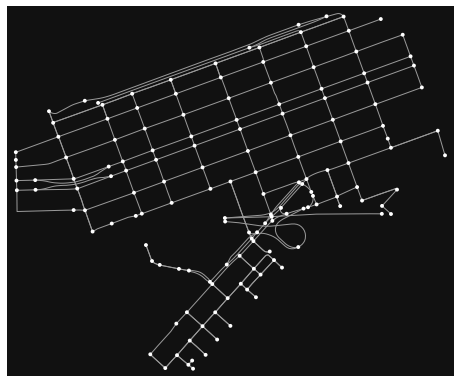

<Figure size 432x288 with 0 Axes>

In [18]:
ox.config(log_console=False, use_cache=False)
# Get the ROADS and NODES of Back bay, Boston
# NODES(white dots) and EDGES(grey lines) are stored in Digraph
place_name = "Back Bay, Massachusetts, USA"
mode = 'drive'
optimizer = 'length'
graph = ox.graph_from_place(place_name,network_type=mode)
fig, ax = ox.plot_graph(graph)
plt.tight_layout()

In [19]:
# Extract NODES and EDGES
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)

In [20]:
nodes

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
61340721,42.351513,-71.086995,4,NaN,NaN,POINT (-71.08700 42.35151)
61340738,42.350897,-71.077742,4,NaN,NaN,POINT (-71.07774 42.35090)
61340743,42.351478,-71.075600,4,NaN,NaN,POINT (-71.07560 42.35148)
61340777,42.350843,-71.089478,4,NaN,NaN,POINT (-71.08948 42.35084)
61340918,42.351919,-71.085492,4,NaN,NaN,POINT (-71.08549 42.35192)
...,...,...,...,...,...,...
7597279640,42.346796,-71.085049,3,NaN,NaN,POINT (-71.08505 42.34680)
7703847341,42.346233,-71.078573,3,NaN,NaN,POINT (-71.07857 42.34623)
7775135474,42.348102,-71.088705,3,NaN,NaN,POINT (-71.08871 42.34810)


In [21]:
# Feed nodes and lengths to algorithms, algo returns bunch of nodes, iterate through the nodes 2 by 2
NodesAndLength = list(graph.edges(data='length'))

EdgeAndLength = {}

for i in NodesAndLength:
    EdgeAndLength[(i[0],i[1])] = i[2]

In [22]:
# === Takes USER INPUTS and Find the nearest nodes on current map ===
print("Thank you for using our Navigator (Back Bay, Boston, USA)!\n\
Please enter your starting location and destination location (in Back Bay, Boston)\n\
You can either enter a place's name or the place's coordinate in this format: latitude, longitude \n\
*Note that only places that could be found on OpenStreetMap can be used*\n\
Recommendations: first church in boston --> Atlantic fish back bay\n\
                 boston architectural college --> gibson house back bay")
# startPoint = sys.argv[1]
# destPoint = sys.argv[2]
# startPoint = input("Your starting location: ")
# destPoint = input("Your destination: ")
startPoint = "first church in boston"
destPoint = "Atlantic fish back bay"
# ===================================================================

if startPoint[0].isdigit():
    # Enter by HAND
    (start_lat,start_long) = tuple(float(x) for x in startPoint.split(",")) # (latitude, longitude)
    (end_lat,end_long) = tuple(float(x) for x in destPoint.split(",")) # (latitude, longitude)

    orig_node = ox.distance.nearest_nodes(graph, start_long, start_lat)
    dest_node = ox.distance.nearest_nodes(graph, end_long, end_lat)

else:
    # Enter by GEOCODE
    try:
        locator = Nominatim(user_agent = "myapp")
        startPoint = locator.geocode(startPoint)
        print(startPoint.latitude, startPoint.longitude)
    except:
        raise ValueError("Cannot find the place entered for departure.. \nPlease enter a place that exists in OpenStreetMap\n")
    try:
        destPoint = locator.geocode(destPoint)
        print(destPoint.latitude, destPoint.longitude)
    except:
        raise ValueError("Cannot find the place entered for destination.. \nPlease enter a place that exists in OpenStreetMap\n")
        
    (start_long, start_lat) = (startPoint.longitude, startPoint.latitude)
    (end_long, end_lat) = (destPoint.longitude, destPoint.latitude)

    orig_node = ox.distance.nearest_nodes(graph, startPoint.longitude, startPoint.latitude)
    dest_node = ox.distance.nearest_nodes(graph, destPoint.longitude, destPoint.latitude)

print(orig_node)
print(dest_node)

Thank you for using our Navigator (Back Bay, Boston, USA)!
Please enter your starting location and destination location (in Back Bay, Boston)
You can either enter a place's name or the place's coordinate in this format: latitude, longitude 
*Note that only places that could be found on OpenStreetMap can be used*
Recommendations: first church in boston --> Atlantic fish back bay
                 boston architectural college --> gibson house back bay
42.353670300000005 -71.07475378063705
42.3492931 -71.0811812
61341786
349355356


Starting computing shortest paths: Dijkstra, Bellman-Ford, and A* algorithm.

In [23]:
class Graph:
    def __init__(self, num_of_vertices, node_list):
        self.v = num_of_vertices
        self.visited = []
        self.graph = []
        self.node_list = node_list # list of all the nodes
        
    def add_edge(self, u, v, weight):
        self.graph.append([u, v, weight])
    
    def h(self, lat1, lon1, lat2, lon2):
        '''
        TO DO:
        This is to calculate the heuristic distance
        '''
        distance = geodesic((lat1,lon1), (lat2,lon2)).m
        return distance
    
    def get_neighbors(self, n):
        '''
        TO DO: To get the neighbors and weights of node n
        '''
        neighbors_list = []
        reshape_graph = np.array(self.graph).reshape(-1, 3)
        # if n is at the first column
        for array in reshape_graph:
            if n in array[:-2]:
                array = np.delete(array, np.where(array == n))
                neighbors_list.append(array)
        
        return neighbors_list
    
    def dijkstra(self, start_vertex):
        D = {v:float('inf') for v in self.node_list}
        D[start_vertex] = 0
        
        pre_nodes = {}
    
        pq = PriorityQueue()
        pq.put((0, start_vertex))
    
        while not pq.empty():
            (dist, current_vertex) = pq.get()
            self.visited.append(current_vertex)
    
            for node in self.node_list:
                for edge in self.graph:
                    if current_vertex == edge[0] and node == edge[1]:
                        distance = edge[2]
                        if node not in self.visited:
                            old_cost = D[node]
                            new_cost = D[current_vertex] + distance
                            if new_cost < old_cost:
                                pq.put((new_cost, node))
                                D[node] = new_cost

                                pre_nodes[node] = current_vertex
        return D, pre_nodes
    
    def bellman_ford(self, src):
        q = queue.Queue()
        
        inqueue = {v:False for v in self.node_list}
        inqueue[src] = True
        
        distance = {v:float('inf') for v in self.node_list}
        distance[src] = 0
        
        q.put(src)
        
        pre_nodes = {}
        
        while(q.empty() != True):
            node = q.get()
            for edge in self.graph:
                if node == edge[0]:
                    end_node = edge[1]
                    weight = edge[2]
                    if distance[end_node] > distance[node] + weight:
                        distance[end_node] = distance[node] + weight
                        pre_nodes[end_node] = node
                        
                        if inqueue[end_node] == False:
                            q.put(end_node)
                            inqueue[end_node] == True
                            
        return distance, pre_nodes
    
    def a_star_algorithm(self, start, stop, graph):
        # In this open_lst is a list of nodes which have been visited, but who's 
        # neighbours haven't all been always inspected, It starts off with the start node
        # And closed_lst is a list of nodes which have been visited
        # and who's neighbors have been always inspected
        open_lst = set([start])
        closed_lst = set([])
        
        lat1 = graph.nodes[start]['y']
        lon1 = graph.nodes[start]['x']
 
        # poo has present distances from start to all other nodes
        # the default value is +infinity
        poo = {}
        poo[start] = 0
 
        # par contains an adjac mapping of all nodes
        par = {}
        par[start] = start
 
        while len(open_lst) > 0:
            n = None
 
            # it will find a node with the lowest value of f() -
            for v in open_lst:
                lat2 = graph.nodes[v]['y']
                lon2 = graph.nodes[v]['x']
                if n == None or poo[v] + self.h(lat1, lon1, lat2, lon2) < poo[n] + self.h(lat1, lon1, lat2n, lon2n):
                    n = v
                    lat2n = graph.nodes[v]['y']
                    lon2n = graph.nodes[v]['x']
 
            if n == None:
                print('Path does not exist!')
                return None
 
            # if the current node is the stop
            # then we start again from start
            if n == stop:
                reconst_path = []
 
                while par[n] != n:
                    reconst_path.append(n)
                    n = par[n]
 
                reconst_path.append(start)
 
                print('Path found: {}'.format(reconst_path))
                return reconst_path
 
            # for all the neighbors of the current node do
            neighbor_list = self.get_neighbors(n)
            for array in neighbor_list:
                m, weight = array[0], array[1]
              # if the current node is not presentin both open_lst and closed_lst
                # add it to open_lst and note n as it's par
                if m not in open_lst and m not in closed_lst:
                    open_lst.add(m)
                    par[m] = n
                    poo[m] = poo[n] + weight
 
                # otherwise, check if it's quicker to first visit n, then m
                # and if it is, update par data and poo data
                # and if the node was in the closed_lst, move it to open_lst
                else:
                    if poo[m] > poo[n] + weight:
                        poo[m] = poo[n] + weight
                        par[m] = n
 
                        if m in closed_lst:
                            closed_lst.remove(m)
                            open_lst.add(m)
 
            # remove n from the open_lst, and add it to closed_lst
            # because all of his neighbors were inspected
            open_lst.remove(n)
            closed_lst.add(n)
 
        print('Path does not exist!')
        return None

In [24]:
def print_result(previous_nodes, shortest_path, start_node, target_node):
    path = []
    node = target_node
    
    while node != start_node:
        path.append(node)
        node = previous_nodes[node]
 
    # Add the start node manually
    path.append(int(start_node))

    print("We found the following best path with a value of {}.".format(shortest_path[target_node]))
    print(path)
    
    return path, "{:.2f}".format(shortest_path[target_node])

In [25]:
# Dijkstra Algorithm

g = Graph(nodes.shape[0], list(nodes.index))
for t in NodesAndLength:
    g.add_edge(t[0], t[1], t[2])
    
D, pre_nodes1 = g.dijkstra(orig_node)
dij_path, dij_length = print_result(pre_nodes1, D, start_node=orig_node, target_node=dest_node)

dij_path.reverse()
dij_length

We found the following best path with a value of 1548.6380000000001.
[349355356, 3051041198, 3051043395, 8280086764, 61371318, 1038897344, 61371341, 61342109, 61372777, 61374245, 6462995309, 61340743, 61341751, 61343986, 61341770, 61353248, 7541401287, 61341786]


'1548.64'

In [26]:
# Bellman-Ford Algorithm
g = Graph(nodes.shape[0], list(nodes.index))
for t in NodesAndLength:
    g.add_edge(t[0], t[1], t[2])

D, pre_nodes2 = g.bellman_ford(orig_node)
bell_path, bell_length = print_result(pre_nodes2, D, start_node=orig_node, target_node=dest_node)

bell_path.reverse()
bell_length

We found the following best path with a value of 1548.6380000000001.
[349355356, 3051041198, 3051043395, 8280086764, 61371318, 1038897344, 61371341, 61342109, 61372777, 61374245, 6462995309, 61340743, 61341751, 61343986, 61341770, 61353248, 7541401287, 61341786]


'1548.64'

In [27]:
# Astar Algorithm

g = Graph(nodes.shape[0], list(nodes.index))
for t in NodesAndLength:
    g.add_edge(t[0], t[1], t[2])
    
astar_path = g.a_star_algorithm(orig_node, dest_node, graph)
astar_path.reverse()
# Convert float to integer
for i in range(0,len(astar_path)):
    astar_path[i] = int(astar_path[i])
astar_path

Path found: [349355356.0, 3051041198.0, 3051043395.0, 8280086764.0, 61371318.0, 1038897344.0, 61371341.0, 61342109.0, 61372777.0, 61374245.0, 6462995309.0, 61340743.0, 61341751.0, 61343986.0, 61341770.0, 61353248.0, 7541401287.0, 61341786]


[61341786,
 7541401287,
 61353248,
 61341770,
 61343986,
 61341751,
 61340743,
 6462995309,
 61374245,
 61372777,
 61342109,
 61371341,
 1038897344,
 61371318,
 8280086764,
 3051043395,
 3051041198,
 349355356]

In [28]:
# Computer length of Astar's path

astar_length = 0

for i in range(len(astar_path)-1):
    subEdge = (astar_path[i],astar_path[i+1])
    astar_length += EdgeAndLength[subEdge]
    
astar_length = "{:.2f}".format(astar_length)

In [31]:
# Plot the shortest route on Openstreet Map

dijkstra_map = ox.plot_route_folium(graph, dij_path, popup_attribute="length", weight=10, color='lightblue')
bellman_map = ox.plot_route_folium(graph, bell_path, popup_attribute="length", weight=10, color='purple')
astar_map = ox.plot_route_folium(graph, astar_path, popup_attribute="length", weight=10, color='grey')

maps = [dijkstra_map,bellman_map,astar_map]

for i in maps:
    folium.TileLayer('openstreetmap').add_to(i)
    folium.TileLayer('Stamen Terrain').add_to(i)
    folium.TileLayer('Stamen Toner').add_to(i)
    folium.TileLayer('Stamen Water Color').add_to(i)
    folium.TileLayer('cartodbpositron').add_to(i)
    folium.TileLayer('cartodbdark_matter').add_to(i)
    folium.LayerControl().add_to(i)

    # Marker class only accepts coordinates in tuple form
    start_marker = folium.Marker(
                location = (start_lat,start_long),
                popup = "Departure",
                icon = folium.Icon(color='black'))
    end_marker = folium.Marker(
                location = (end_lat,end_long),
                popup = "Destination",
                icon = folium.Icon(color='green'))
    # add the circle marker to the map
    start_marker.add_to(i)
    end_marker.add_to(i)

mapNames = ["Dijkstra","Bellman-Ford","A*"]
pathLengths = [dij_length,bell_length,astar_length]

for i in range(len(mapNames)):
    # Add title
    text = "Shortest path calculated with "+mapNames[i]+" algorithm - Total distance = "+str(pathLengths[i])+" meters"
    title_html = '''
                <h3 align="center" style="font-size:16px"><b>{}</b></h3>
                '''.format(text)  
    maps[i].get_root().html.add_child(folium.Element(title_html))

dijkstra_map

In [30]:
# Save the output map as html file
dijkstra_map.save("./dijkstra_map.html")
bellman_map.save("./bellman_map.html")
astar_map.save("./astar_map.html")

print("\n=========================\nMaps with plotted shortest path are stored in current folder, please open it with your browswer to view the path :)\n=== Program finished ===")


Maps with plotted shortest path are stored in current folder, please open it with your browswer to view the path :)
=== Program finished ===
